## 1. Read the data

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2022-11-09 21:53:26--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7882203 (7.5M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.52M  6.57MB/s    in 1.1s    

2022-11-09 21:53:28 (6.57 MB/s) - ‘ita-eng.zip’ saved [7882203/7882203]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


### Importing the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers Dense
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
with open('/content/ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(358373, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Preprocessing the data

In [ ]:
def decontractions(phrase):
   
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text

In [ ]:
data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
data.shape

(358373, 2)

In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

Analysis of the length of an Italian sentence 

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


Analysis of the length of an English sentence 

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


### We can observe that 99.9% of the data points are having length less than 20, so we will select those sentences which have words less than 20.

### In order to implement teacher forcing while training the sequence to sequence model, we will create two new columns, one column will have <start> token at begining of the sentence and the other column will have <end> token at the end of the sentence.

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)

data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


## 3. Train and test split

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2,random_state=42)

In [ ]:
train.head()

,italian,english_inp,english_out
202468,non penso che sia colpa mia,<start> i do not think it is my fault,i do not think it is my fault <end>
142250,ci si vede fra tre mesi,<start> see you in three months,see you in three months <end>
9500,aiutatemi e basta,<start> just help me,just help me <end>
310927,tom ci ha detto che la stanza era chiusa a chiave,<start> tom told us that the room was locked,tom told us that the room was locked <end>
148333,perché non lascia tom,<start> why do not you leave tom,why do not you leave tom <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
226287,tom è stato fortunato ad ottenere il lavoro,<start> tom was lucky to get the job,tom was lucky to get the job <end>
190020,mia sorella gioca con delle bambole,<start> my sister plays with dolls,my sister plays with dolls <end>
182491,lei riesce a risolvere questo indovinello,<start> can you answer this riddle,can you answer this riddle <end>
115557,a che ora ha mangiato,<start> what time did you eat,what time did you eat <end>
274549,la nostra visita è stata molto piacevole,<start> our visit has been very pleasant,our visit has been very pleasant <end>


In [ ]:
print(train.shape,validation.shape)

(286292, 3) (71574, 3)


### We will be adding <end> token so that the tokenizer learns the word <end>. In this way, we can use only one tokenizer for both encoder output and decoder output.

In [ ]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [ ]:
train.head()

,italian,english_inp,english_out
202468,non penso che sia colpa mia,<start> i do not think it is my fault <end>,i do not think it is my fault <end> <end>
142250,ci si vede fra tre mesi,<start> see you in three months,see you in three months <end>
9500,aiutatemi e basta,<start> just help me,just help me <end>
310927,tom ci ha detto che la stanza era chiusa a chiave,<start> tom told us that the room was locked,tom told us that the room was locked <end>
148333,perché non lascia tom,<start> why do not you leave tom,why do not you leave tom <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
226287,tom è stato fortunato ad ottenere il lavoro,<start> tom was lucky to get the job,tom was lucky to get the job <end>
190020,mia sorella gioca con delle bambole,<start> my sister plays with dolls,my sister plays with dolls <end>
182491,lei riesce a risolvere questo indovinello,<start> can you answer this riddle,can you answer this riddle <end>
115557,a che ora ha mangiato,<start> what time did you eat,what time did you eat <end>
274549,la nostra visita è stata molto piacevole,<start> our visit has been very pleasant,our visit has been very pleasant <end>


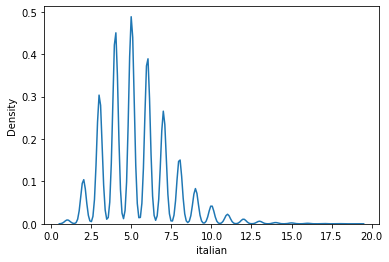

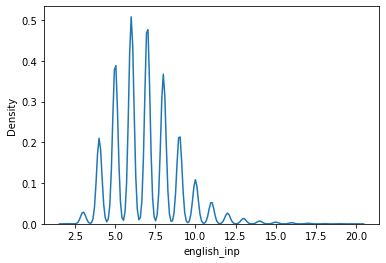

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### We will now create a tokenizer for the train data and learn the vocabulary. From the filters, we will remove the symbols < and >.


In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13159
26771


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10412)

## 4. Implement a custom Encoder and Decoder

### Encoder Architecture

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        super(Encoder,self).__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_length
        self.lstm_size = lstm_size

        self.embedding = Embedding(input_dim = self.inp_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,name="embedding_layer_encoder")                          
        
        self.lstm = LSTM(self.lstm_size,return_state=True,return_sequences=True,name="Encoder_LSTM")
                         
        

    def call(self,input_sequence,states):
        
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state = [states[0], states[1]])
                
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      
    
    def initialize_states(self,batch_size):
      
      self.initial_hidden_state = tf.zeros((batch_size, self.lstm_size))
      self.initial_cell_state = tf.zeros((batch_size, self.lstm_size))

      return self.initial_hidden_state,self.initial_cell_state
   

### Decoder Architecture

In [ ]:
class Decoder(tf.keras.Model):

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super(Decoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_length
        self.lstm_size = lstm_size
           
        self.embedding = Embedding(input_dim = self.out_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,name="embedding_layer_decoder")
                                                               
        self.lstm = LSTM(self.lstm_size, return_sequences=True,return_state=True, name="Decoder_LSTM")
                         
        

    def call(self,target_sentances,initial_states):
      
        target_embedd = self.embedding(target_sentances)
        self.decoder_output,decoder_final_state_h,decoder_final_state_c = self.lstm(target_embedd, initial_state = [initial_states[0], initial_states[1]])
        
        return self.decoder_output,decoder_final_state_h,decoder_final_state_c

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,enco_inp_len,
                 deco_inp_len,
                 enco_vocab_size,
                 deco_vocab_size,
                 enco_embed_size,
                 deco_embed_size,
                 out_vocab_size):
        super().__init__()
        self.enco_inp_len=enco_inp_len
        self.deco_inp_len=deco_inp_len
        self.enco_vocab_size=enco_vocab_size
        self.deco_vocab_size=deco_vocab_size
        self.enco_embed_size= enco_embed_size
        self.deco_embed_size= deco_embed_size
        self.out_vocab_size=out_vocab_size
        
        self.encoder = Encoder(inp_vocab_size = self.enco_vocab_size, embedding_size = self.enco_embed_size,input_length = self.enco_inp_len,lstm_size=256)
                               
                              
        self.decoder = Decoder(out_vocab_size = deco_vocab_size,embedding_size= deco_embed_size,input_length = deco_inp_len, lstm_size=256)
                               
                            
        self.dense = Dense(out_vocab_size, activation='softmax')
        
    
    def call(self,data):
       
        enco_inp,deco_inp = data[0], data[1]
        init_state = self.encoder.initialize_states(1024)
        enco_out, enco_hid_state, enco_cell_state = self.encoder(enco_inp,init_state)
        deco_out,_,_ = self.decoder(deco_inp, [enco_hid_state, enco_cell_state])
        output = self.dense(deco_out)
        return output

### We will now create a data pipeline.

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): 
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)


In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


## 5. Model training

In [ ]:
model_1  = Encoder_decoder(enco_inp_len = 20,
                         deco_inp_len = 20,
                         enco_vocab_size = vocab_size_ita + 1,
                         deco_vocab_size = vocab_size_eng + 1,
                         enco_embed_size = 100,
                         deco_embed_size = 100,
                         out_vocab_size = vocab_size_eng)

optimizer = tf.keras.optimizers.Adam()

model_1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

log_dir = '/content/drive/MyDrive/Seq2Seq_Implementation/logs'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True)


In [ ]:
model_1.fit(x=train_dataloader,
            steps_per_epoch = train_steps,
            epochs = 20,
            validation_data = test_dataloader,
            validation_steps = valid_steps,
            callbacks = [tb_callback])

Epoch 1/20
279/279 [==============================] - 70s 241ms/step - loss: 2.2751 - val_loss: 1.6429
Epoch 2/20
279/279 [==============================] - 70s 251ms/step - loss: 1.5358 - val_loss: 1.4173
Epoch 3/20
279/279 [==============================] - 71s 253ms/step - loss: 1.3038 - val_loss: 1.2097
Epoch 4/20
279/279 [==============================] - 71s 253ms/step - loss: 1.1375 - val_loss: 1.0668
Epoch 5/20
279/279 [==============================] - 72s 257ms/step - loss: 0.9993 - val_loss: 0.9415
Epoch 6/20
279/279 [==============================] - 71s 253ms/step - loss: 0.8737 - val_loss: 0.8244
Epoch 7/20
279/279 [==============================] - 71s 256ms/step - loss: 0.7531 - val_loss: 0.7173
Epoch 8/20
279/279 [==============================] - 71s 253ms/step - loss: 0.6414 - val_loss: 0.6218
Epoch 9/20
279/279 [==============================] - 71s 253ms/step - loss: 0.5418 - val_loss: 0.5354
Epoch 10/20
279/279 [==============================] - 71s 254ms/step - l

In [ ]:
model_1.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3042768   
                                                                 
 decoder_1 (Decoder)         multiple                  1681568   
                                                                 
 dense (Dense)               multiple                  3381863   
                                                                 
Total params: 8,106,199
Trainable params: 8,106,199
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tknizer_eng.word_index

{'<start>': 1,
 'i': 2,
 'you': 3,
 'tom': 4,
 'to': 5,
 'is': 6,
 'not': 7,
 'the': 8,
 'do': 9,
 'a': 10,
 'are': 11,
 'have': 12,
 'it': 13,
 'that': 14,
 'he': 15,
 'was': 16,
 'am': 17,
 'in': 18,
 'we': 19,
 'me': 20,
 'will': 21,
 'did': 22,
 'of': 23,
 'this': 24,
 'be': 25,
 'what': 26,
 'can': 27,
 'for': 28,
 'your': 29,
 'my': 30,
 'want': 31,
 'mary': 32,
 'with': 33,
 'like': 34,
 'why': 35,
 'know': 36,
 'think': 37,
 'go': 38,
 'his': 39,
 'here': 40,
 'she': 41,
 'at': 42,
 'would': 43,
 'they': 44,
 'very': 45,
 'on': 46,
 'how': 47,
 'has': 48,
 'and': 49,
 'there': 50,
 'about': 51,
 'does': 52,
 'now': 53,
 'were': 54,
 'all': 55,
 'going': 56,
 'so': 57,
 'should': 58,
 'need': 59,
 'get': 60,
 'help': 61,
 'boston': 62,
 'as': 63,
 'time': 64,
 'us': 65,
 'an': 66,
 'him': 67,
 'really': 68,
 'good': 69,
 'who': 70,
 'tell': 71,
 'one': 72,
 'had': 73,
 'still': 74,
 'never': 75,
 'too': 76,
 'where': 77,
 'see': 78,
 'come': 79,
 'just': 80,
 'been': 81,
 'her':

In [ ]:
eng_dict_index_word={}

for k,v in tknizer_eng.word_index.items():
  eng_dict_index_word[v]=k

eng_dict_index_word

{1: '<start>',
 2: 'i',
 3: 'you',
 4: 'tom',
 5: 'to',
 6: 'is',
 7: 'not',
 8: 'the',
 9: 'do',
 10: 'a',
 11: 'are',
 12: 'have',
 13: 'it',
 14: 'that',
 15: 'he',
 16: 'was',
 17: 'am',
 18: 'in',
 19: 'we',
 20: 'me',
 21: 'will',
 22: 'did',
 23: 'of',
 24: 'this',
 25: 'be',
 26: 'what',
 27: 'can',
 28: 'for',
 29: 'your',
 30: 'my',
 31: 'want',
 32: 'mary',
 33: 'with',
 34: 'like',
 35: 'why',
 36: 'know',
 37: 'think',
 38: 'go',
 39: 'his',
 40: 'here',
 41: 'she',
 42: 'at',
 43: 'would',
 44: 'they',
 45: 'very',
 46: 'on',
 47: 'how',
 48: 'has',
 49: 'and',
 50: 'there',
 51: 'about',
 52: 'does',
 53: 'now',
 54: 'were',
 55: 'all',
 56: 'going',
 57: 'so',
 58: 'should',
 59: 'need',
 60: 'get',
 61: 'help',
 62: 'boston',
 63: 'as',
 64: 'time',
 65: 'us',
 66: 'an',
 67: 'him',
 68: 'really',
 69: 'good',
 70: 'who',
 71: 'tell',
 72: 'one',
 73: 'had',
 74: 'still',
 75: 'never',
 76: 'too',
 77: 'where',
 78: 'see',
 79: 'come',
 80: 'just',
 81: 'been',
 82: 'h

In [ ]:
def predict(input_sentence):

  encoder_input = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_padding = pad_sequences(encoder_input,maxlen=20, dtype='int32', padding='post')
  init_state = model_1.layers[0].initialize_states(1)
  encoder_output, enco_hid_state, enco_cell_state = model_1.layers[0](encoder_padding,init_state)
  states = [enco_hid_state, enco_cell_state]
  
  sent = ''

  eng_word = np.array([[1]])
  
  for i in range(20):
      [output, hid_state, cell_state] = model_1.layers[1](eng_word, states)
      output = model_1.layers[2](output)
      states = [hid_state, cell_state]
      eng_word = np.reshape(np.argmax(output),(1, 1))
      sent=sent + ' ' + eng_dict_index_word[int(eng_word)]
      if eng_dict_index_word[int(eng_word)]=='<end>':
        break
  return sent

In [ ]:
predict('ci si vede fra tre mesi')

' see you in three months <end>'

### We will be using BLEU score as as a metric to evaluate our model's performance.

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu

np.random.seed(42)

bleu_scores_list = []

for i in tqdm(range(1000)):
    id = np.random.randint(1,68677)
    actual_sent = [validation['english_out'].iloc[id].split(),]
    pred = predict(validation['italian'].iloc[id]).split()
    score = bleu.sentence_bleu(actual_sent, pred)
    bleu_scores_list.append(score)

print('Average bleu score is:',np.average(bleu_scores_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

Average bleu score is: 0.40537788649885464


## 6. Including Attention Mechanism

### Encoder and Decoder architecture with Attention layers

#### Encoder Architecture

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        super(Encoder,self).__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_length
        self.lstm_size = lstm_size

      
        self.embedding = Embedding(input_dim = self.inp_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,name="embedding_layer_encoder")
                                    
                                   
        self.lstm = LSTM(self.lstm_size,return_state=True,return_sequences=True,name="Encoder_LSTM")
        
                         

    def call(self,input_sequence,states):
        
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state = [states[0], states[1]])
                
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
      
      self.initial_hidden_state = tf.zeros((batch_size, self.lstm_size))
      self.initial_cell_state = tf.zeros((batch_size, self.lstm_size))

      return self.initial_hidden_state,self.initial_cell_state
   

### Attention layers

In [ ]:
class Attention(tf.keras.layers.Layer):
 
  def __init__(self,scoring_function, att_units):
    super(Attention,self).__init__()
    self.scoring_function = scoring_function
  

    if self.scoring_function=='dot':
      
      pass  

    if scoring_function == 'general':
    
      self.W1 = tf.keras.layers.Dense(att_units)
      pass

    elif scoring_function == 'concat':
    
      self.W1 = tf.keras.layers.Dense(att_units)
      self.W2 = tf.keras.layers.Dense(att_units)
      self.V = tf.keras.layers.Dense(1)
      pass

    
  def call(self,deco_hid_state,enco_out):
    
    if self.scoring_function == 'dot':

      deco_hid_state = tf.expand_dims(deco_hid_state,-1) 
      score = tf.matmul(enco_out,deco_hid_state) 
      att_weights = tf.nn.softmax(score,axis=1)
      context_vec = att_weights*enco_out
      context_vec = tf.reduce_sum(context_vec,axis=1)
      pass

    if self.scoring_function == 'general':
      
      deco_hid_state = tf.expand_dims(deco_hid_state,-1)
      score = self.W1(enco_out)
      score = tf.matmul(score,deco_hid_state)
      att_weights = tf.nn.softmax(score,axis=1)
      context_vec = att_weights*enco_out
      context_vec = tf.reduce_sum(context_vec,axis=1)
      pass

    elif self.scoring_function == 'concat':
      
      deco_hid_state = tf.expand_dims(deco_hid_state,1)
      score = self.V(tf.nn.tanh(self.W1(deco_hid_state) + self.W2(enco_out)))
      att_weights = tf.nn.softmax(score,axis=1)
      context_vec = att_weights* enco_out
      context_vec = tf.reduce_sum(context_vec,axis=1)
      pass

    
    return context_vec,att_weights


### One Step Decoder Architecture

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super(One_Step_Decoder,self).__init__()
      self.tar_vocab_size=tar_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun = score_fun
      self.att_units = att_units

    
      self.embedding = Embedding(input_dim = self.tar_vocab_size,output_dim = self.embedding_dim, input_length = self.input_length,name='embedding_layer_decoder') 
                                  

      self.LSTM_layer_1 = LSTM(self.dec_units, return_sequences=True,return_state=True, name="Decoder_LSTM_layer_1")
      self.LSTM_layer_2 = LSTM(self.dec_units, return_sequences=True,return_state=True, name="Decoder_LSTM_layer_2")
      
      
      self.full_conn = tf.keras.layers.Dense(self.tar_vocab_size)
      self.attention = Attention(self.score_fun,self.att_units)
      
  def call(self,decoder_inp, enco_out, hidden_state,cell_state):
    
    decoder_inp = self.embedding(decoder_inp)
    deco_out,deco_hid_state,deco_cell_state = self.LSTM_layer_1(enco_out, initial_state = [hidden_state, cell_state])

    context_vec, att_weights = self.attention(deco_hid_state, enco_out)

    decoder_inp = tf.concat([tf.expand_dims(context_vec,axis = 1),decoder_inp ], axis=-1)

    deco_out , hidden_state, hidden_cell_state = self.LSTM_layer_2(decoder_inp)

    deco_out = tf.reshape(deco_out, (-1, deco_out.shape[2]))

    output = self.full_conn(deco_out)

    return output,hidden_state,hidden_cell_state,att_weights,context_vec



### Decoder Architecture

In [ ]:
class Decoder(tf.keras.Model):
  
    def __init__(self,out_vocab_size, embedding_size, input_length, lstm_size ,score_fun ,att_units):
     
      super(Decoder,self).__init__()

      self.out_vocab_size = out_vocab_size
      self.embedding_size = embedding_size
      self.input_length = input_length
      self.lstm_size = lstm_size
      self.score_fun = score_fun
      self.att_units = att_units

      self.onestep_decoder = One_Step_Decoder(self.out_vocab_size,self.embedding_size,self.input_length,self.lstm_size,self.score_fun,self.att_units)
                                              
                              
        
    def call(self, decoder_inp,enco_out,deco_hid_state,deco_cell_state ):

        outputs_array = tf.TensorArray(tf.float32,size=self.input_length,name='all_output_array')
        
        for time in range(self.input_length):
            output,deco_hid_state,deco_cell_state,attention_weights,contex_vector = self.onestep_decoder(decoder_inp[:,time:time+1],enco_out,deco_hid_state,deco_cell_state)
            outputs_array = outputs_array.write(time,output)
        outputs_array = tf.transpose(outputs_array.stack(),[1,0,2])
    
        return outputs_array

### Encoder Decoder Architecture

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enco_vocab_size,enco_embed_size,
               enc_units,enco_inp_len,
               out_vocab_size, deco_embed_size,
               deco_inp_len, dec_units,
               score_fun ,att_units
               ):
      super(encoder_decoder,self).__init__()
      self.enco_vocab_size=enco_vocab_size
      self.enco_embed_size=enco_embed_size
      self.enc_units=enc_units
      self.enco_inp_len=enco_inp_len
      self.out_vocab_size=out_vocab_size
      self.deco_embed_size=deco_embed_size
      self.deco_inp_len=deco_inp_len
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units

     
      self.encoder = Encoder(self.enco_vocab_size,self.enco_embed_size,self.enc_units,self.enco_inp_len)
                             

    
      self.decoder = Decoder(self.out_vocab_size, self.deco_embed_size,self.deco_inp_len, self.dec_units,self.score_fun, self.att_units)
                              

  
  def call(self,data):

    enco_inp,deco_inp = data[0], data[1]
    init_state = self.encoder.initialize_states(1024)
    enco_out, enco_hid_state, enco_cell_state = self.encoder(enco_inp,init_state)
    deco_hid_state = enco_hid_state
    deco_cell_state = enco_cell_state
    deco_out  = self.decoder(deco_inp,enco_out,deco_hid_state, deco_cell_state)
                                                         
    return deco_out

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 7. Model Training

### Train using Dot Scoring Function

#### Implemening the dot scoring function.

In [ ]:
#Create an object of encoder_decoder Model class, 
model_2  = encoder_decoder(enco_vocab_size = vocab_size_ita + 1,enco_embed_size = 100,enc_units = 256, enco_inp_len = 20,out_vocab_size = vocab_size_eng + 1,deco_embed_size = 100, deco_inp_len = 20, dec_units = 256,score_fun = 'dot', att_units = 256)
                                                                                                                                                                                                                                                                                                
# Compile the model and fit the model
optimizer = tf.keras.optimizers.Adam()
model_2.compile(optimizer = optimizer,loss = loss_function)

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024


In [ ]:
# tensorboard callback
log_dir = '/content/drive/MyDrive/Seq2Seq_Implementation/logs2'
tb_callback = TensorBoard(log_dir=log_dir)

# model checkpoint
path_1 = '/content/drive/MyDrive/Seq2Seq_Implementation/checkpoint'
mc_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_1,save_weights_only=True,monitor='val_loss', save_best_only=True)
    

In [ ]:
model_2.fit(x=train_dataloader,steps_per_epoch = train_steps,epochs = 30,validation_data = test_dataloader,validation_steps = valid_steps,callbacks = [tb_callback,mc_callback])
          

Epoch 1/30
279/279 [==============================] - 228s 813ms/step - loss: 1.4676 - val_loss: 1.4333
Epoch 2/30
279/279 [==============================] - 227s 814ms/step - loss: 1.4201 - val_loss: 1.3979
Epoch 3/30
279/279 [==============================] - 227s 814ms/step - loss: 1.3892 - val_loss: 1.3749
Epoch 4/30
279/279 [==============================] - 227s 815ms/step - loss: 1.3676 - val_loss: 1.3579
Epoch 5/30
279/279 [==============================] - 227s 815ms/step - loss: 1.3511 - val_loss: 1.3451
Epoch 6/30
279/279 [==============================] - 227s 814ms/step - loss: 1.3378 - val_loss: 1.3346
Epoch 7/30
279/279 [==============================] - 227s 815ms/step - loss: 1.3268 - val_loss: 1.3258
Epoch 8/30
279/279 [==============================] - 227s 815ms/step - loss: 1.3174 - val_loss: 1.3182
Epoch 9/30
279/279 [==============================] - 228s 816ms/step - loss: 1.3094 - val_loss: 1.3121
Epoch 10/30
279/279 [==============================] - 228s 817m

In [ ]:
model_2.summary()

Model: "encoder_decoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  3042768   
                                                                 
 decoder_5 (Decoder)         multiple                  5851144   
                                                                 
Total params: 8,893,912
Trainable params: 8,893,912
Non-trainable params: 0
_________________________________________________________________


### Plotting Attention Weights

In [ ]:
def plot_attention(att, sent, pred_sent):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  
  fig = plt.figure(figsize=(10,10))
  x = fig.add_subplot(1, 1, 1)
  x.matshow(att, cmap='viridis')

  dict1 = {'fontsize': 15}

  x.set_xticklabels([''] + sent, fontdict=dict1, rotation=90)
  x.set_yticklabels([''] + pred_sent, fontdict=dict1)

  x.xaxis.set_major_locator(ticker.MultipleLocator(1))
  x.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

### Predict the translated sentence.

In [ ]:
def predict(input_sentence):
 
  enco_inp = tknizer_ita.texts_to_sequences([input_sentence])
  enco_inp = pad_sequences(enco_inp,maxlen=20, dtype='int32', padding='post')
  enco_inp = tf.convert_to_tensor(enco_inp)

  init_state = model_2.layers[0].initialize_states(1)

  sent = ''

  deco_inp = np.array([[1]])

  att_plot = np.zeros((20,20))

  enco_out, enco_hid_state, enc_cell_state = model_2.layers[0](enco_inp,init_state)
  deco_hid_state = enco_hid_state
  deco_cell_state = enc_cell_state

  for t in range(20):
        pred, deco_hid_state, deco_cell_state,att_weights,context_vec = model_2.layers[1].onestep_decoder(deco_inp, enco_out, deco_hid_state,deco_cell_state)
            
        att_weights = tf.reshape(att_weights, (-1, ))
        att_plot[t] = att_weights.numpy()

        pred_id = tf.argmax(pred[0]).numpy()

        sent += tknizer_eng.index_word[pred_id] + ' '

        if tknizer_eng.index_word[pred_id] == '<end>':
            return sent, input_sentence , att_plot
        
        
        deco_inp = tf.expand_dims([pred_id], 0)

  return sent, input_sentence, att_plot


In [ ]:
# Function to make attention plot

def translate(input_sentence):
  res, sent, att_plot = predict(input_sentence)

  print('Input: %s' % (sent))
  print('Predicted translation: {}'.format(res))

  att_plot = att_plot[:len(res.split(' ')), :len(sent.split(' '))]
  plot_attention(att_plot, sent.split(' '), res.split(' '))

  return input_sentence,res

#### Attention Plots for some random inputs

Input: ci si vede fra tre mesi
Predicted translation: see you in three months <end> 


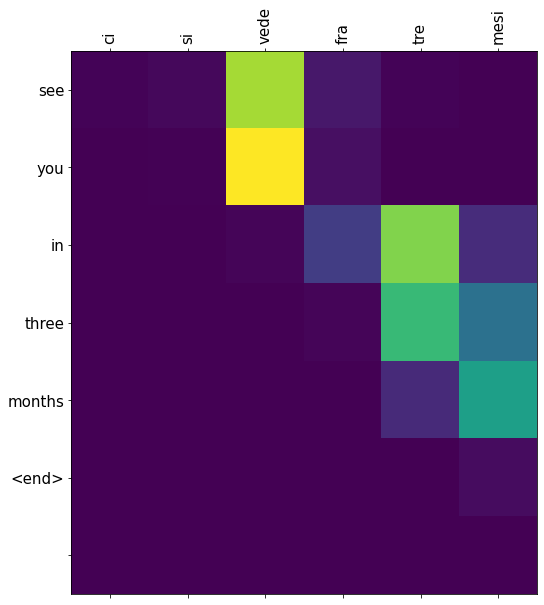

('ci si vede fra tre mesi', 'see you in three months <end> ')

In [ ]:
translate('ci si vede fra tre mesi')

Input: non penso che sia colpa mia
Predicted translation: i do not think that is my fault <end> 


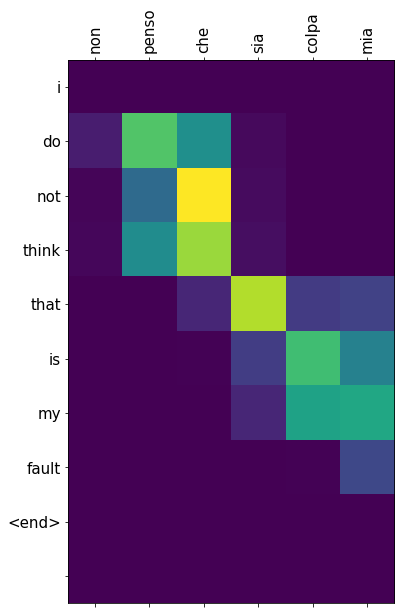

('non penso che sia colpa mia', 'i do not think that is my fault <end> ')

In [ ]:
translate('non penso che sia colpa mia')

Input: perché non lascia tom
Predicted translation: why do not you leave tom <end> 


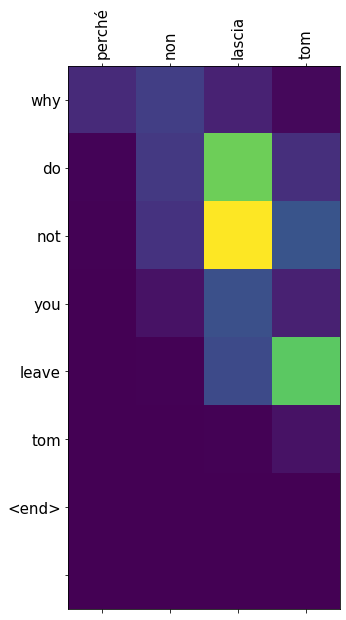

('perché non lascia tom', 'why do not you leave tom <end> ')

In [ ]:
translate('perché non lascia tom')

### We will be using BLEU score as a metric to evaluate our model's performance.

#### Calculation of Average BLEU score for dot scoring attention model

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu

np.random.seed(42)

bleu_scores_dot_list = []

for i in tqdm(range(1000)):
    id = np.random.randint(1,68677)
    actual_sent = [validation['english_out'].iloc[id].split(),]
    pred,_,_ = predict(validation['italian'].iloc[id])
    pred = pred.split()
    score = bleu.sentence_bleu(actual_sent, pred)
    bleu_scores_dot_list.append(score)

print('Average bleu score using dot scoring is:',np.average(bleu_scores_dot_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

Average bleu score using dot scoring is: 0.5669195441514694


### We will redo all the steps for general scoring function.

In [ ]:
#Create an object of encoder_decoder Model class, 
model_3  = encoder_decoder(enco_vocab_size = vocab_size_ita + 1,enco_embed_size = 100,enc_units = 256,enco_inp_len = 20,out_vocab_size = vocab_size_eng + 1, deco_embed_size = 100,deco_inp_len = 20, dec_units = 256, score_fun = 'general', att_units = 256)
                                           
                        
# Compile the model and fit the model
optimizer = tf.keras.optimizers.Adam()
model_3.compile(optimizer = optimizer,loss = loss_function)


train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024



In [ ]:
# tensorboard callback
log_dir = '/content/drive/MyDrive/Seq2Seq_Implementation/logs_general'
tb_callback = TensorBoard(log_dir=log_dir)

# model checkpoint
path_2 = '/content/drive/MyDrive/Seq2Seq_Implementation/checkpoint2'
mc_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_2,save_weights_only=True, monitor='val_loss',save_best_only=True)
    

In [ ]:
model_3.fit(x=train_dataloader,steps_per_epoch = train_steps,epochs = 35,validation_data = test_dataloader,validation_steps = valid_steps,callbacks = [tb_callback,mc_callback])
  

Epoch 1/35
279/279 [==============================] - 305s 914ms/step - loss: 1.9627 - val_loss: 1.7993
Epoch 2/35
279/279 [==============================] - 242s 869ms/step - loss: 1.6803 - val_loss: 1.5790
Epoch 3/35
279/279 [==============================] - 243s 872ms/step - loss: 1.5354 - val_loss: 1.4837
Epoch 4/35
279/279 [==============================] - 243s 871ms/step - loss: 1.4632 - val_loss: 1.4320
Epoch 5/35
279/279 [==============================] - 243s 872ms/step - loss: 1.4200 - val_loss: 1.3984
Epoch 6/35
279/279 [==============================] - 242s 869ms/step - loss: 1.3891 - val_loss: 1.3741
Epoch 7/35
279/279 [==============================] - 243s 872ms/step - loss: 1.3667 - val_loss: 1.3571
Epoch 8/35
279/279 [==============================] - 243s 872ms/step - loss: 1.3500 - val_loss: 1.3437
Epoch 9/35
279/279 [==============================] - 243s 872ms/step - loss: 1.3366 - val_loss: 1.3332
Epoch 10/35
279/279 [==============================] - 243s 872m

In [ ]:
model_3.summary()

Model: "encoder_decoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_6 (Encoder)         multiple                  3042768   
                                                                 
 decoder_6 (Decoder)         multiple                  5916936   
                                                                 
Total params: 8,959,704
Trainable params: 8,959,704
Non-trainable params: 0
_________________________________________________________________


### Predict the sentence translated using general scoring function.

In [ ]:
def predict(input_sentence):

  enco_inp = tknizer_ita.texts_to_sequences([input_sentence])
  enco_inp = pad_sequences(enco_inp,maxlen=20, dtype='int32', padding='post')
  enco_inp = tf.convert_to_tensor(enco_inp)

  init_state = model_3.layers[0].initialize_states(1)

  sent = ''

  deco_inp = np.array([[1]])

  att_plot = np.zeros((20,20))

  enco_out, enco_hid_state, enc_cell_state = model_3.layers[0](enco_inp,init_state)
  deco_hid_state = enco_hid_state
  deco_cell_state = enc_cell_state

  for t in range(20):
        pred, deco_hid_state, deco_cell_state,att_weights,context_vec = model_3.layers[1].onestep_decoder(deco_inp, enco_out, deco_hid_state,deco_cell_state)
            
        att_weights = tf.reshape(att_weights, (-1, ))
        att_plot[t] = att_weights.numpy()

        pred_id = tf.argmax(pred[0]).numpy()

        sent += tknizer_eng.index_word[pred_id] + ' '

        if tknizer_eng.index_word[pred_id] == '<end>':
            return sent, input_sentence , att_plot
        
        
        deco_inp = tf.expand_dims([pred_id], 0)

  return sent, input_sentence, att_plot




#### Attention Plots for some random inputs

Input: ci si vede fra tre mesi
Predicted translation: see you in three months <end> 


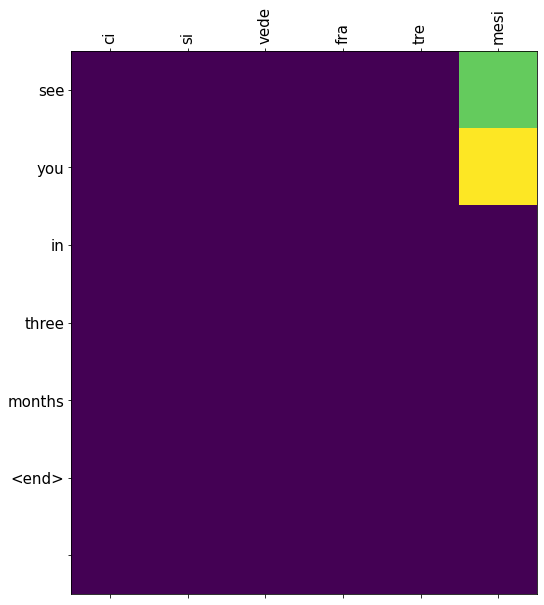

('ci si vede fra tre mesi', 'see you in three months <end> ')

In [ ]:
translate('ci si vede fra tre mesi')

Input: non penso che sia colpa mia
Predicted translation: i do not think it is my fault <end> 


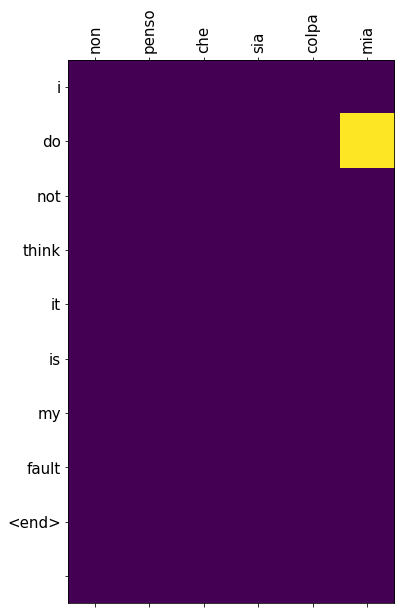

('non penso che sia colpa mia', 'i do not think it is my fault <end> ')

In [ ]:
translate('non penso che sia colpa mia')

Input: perché non lascia tom
Predicted translation: why do not you leave tom <end> 


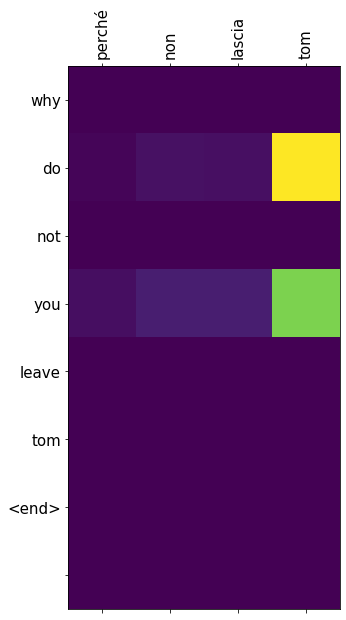

('perché non lascia tom', 'why do not you leave tom <end> ')

In [ ]:
translate('perché non lascia tom')

#### Calculation of Average BLEU score for general scoring attention model

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu

np.random.seed(42)

bleu_scores_general_list = []

for i in tqdm(range(1000)):
    id = np.random.randint(1,68677)
    actual_sent = [validation['english_out'].iloc[id].split(),]
    pred,_,_ = predict(validation['italian'].iloc[id])
    pred = pred.split()
    score = bleu.sentence_bleu(actual_sent, pred)
    bleu_scores_general_list.append(score)

print('Average bleu score using general scoring is:',np.average(bleu_scores_general_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

Average bleu score using general scoring is: 0.5475324823804651


### We will redo all the steps for concat scoring function.

In [ ]:
model_4  = encoder_decoder(enco_vocab_size = vocab_size_ita + 1,enco_embed_size = 100,enc_units = 256,enco_inp_len = 20,out_vocab_size = vocab_size_eng + 1,deco_embed_size = 100, deco_inp_len = 20, dec_units = 256, score_fun = 'concat', att_units = 256)                    
                         

# Compile the model and fit the model
optimizer = tf.keras.optimizers.Adam()
model_4.compile(optimizer = optimizer,loss = loss_function)


train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024


In [ ]:
# tensorboard callback
log_dir = '/content/drive/MyDrive/Seq2Seq_Implementation/logs_concat'
tb_callback = TensorBoard(log_dir=log_dir)

# model checkpoint
path_3 = '/content/drive/MyDrive/Seq2Seq_Implementation/checkpoint3'
mc_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_3,save_weights_only=True, monitor='val_loss', save_best_only=True)
  

In [ ]:
model_4.fit(x=train_dataloader,steps_per_epoch = train_steps,epochs = 25,validation_data = test_dataloader,validation_steps = valid_steps,callbacks = [tb_callback,mc_callback])
    

Epoch 1/25
279/279 [==============================] - 312s 939ms/step - loss: 1.9604 - val_loss: 1.8046
Epoch 2/25
279/279 [==============================] - 250s 895ms/step - loss: 1.6572 - val_loss: 1.4962
Epoch 3/25
279/279 [==============================] - 251s 899ms/step - loss: 1.3821 - val_loss: 1.2794
Epoch 4/25
279/279 [==============================] - 251s 899ms/step - loss: 1.2135 - val_loss: 1.1426
Epoch 5/25
279/279 [==============================] - 251s 899ms/step - loss: 1.0765 - val_loss: 1.0115
Epoch 6/25
279/279 [==============================] - 251s 899ms/step - loss: 0.9438 - val_loss: 0.8828
Epoch 7/25
279/279 [==============================] - 251s 899ms/step - loss: 0.8120 - val_loss: 0.7564
Epoch 8/25
279/279 [==============================] - 251s 900ms/step - loss: 0.6822 - val_loss: 0.6400
Epoch 9/25
279/279 [==============================] - 251s 899ms/step - loss: 0.5667 - val_loss: 0.5429
Epoch 10/25
279/279 [==============================] - 251s 900m

In [ ]:
model_4.summary()

Model: "encoder_decoder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  3042768   
                                                                 
 decoder_7 (Decoder)         multiple                  5982985   
                                                                 
Total params: 9,025,753
Trainable params: 9,025,753
Non-trainable params: 0
_________________________________________________________________


### Predict the sentence translated using concat scoring function.

In [ ]:
def predict(input_sentence):
 
  enco_inp = tknizer_ita.texts_to_sequences([input_sentence])
  enco_inp = pad_sequences(enco_inp,maxlen=20, dtype='int32', padding='post')
  enco_inp = tf.convert_to_tensor(enco_inp)

  init_state = model_4.layers[0].initialize_states(1)

  sent = ''

  deco_inp = np.array([[1]])

  att_plot = np.zeros((20,20))

  enco_out, enco_hid_state, enc_cell_state = model_4.layers[0](enco_inp,init_state)
  deco_hid_state = enco_hid_state
  deco_cell_state = enc_cell_state

  for t in range(20):
        pred, deco_hid_state, deco_cell_state,att_weights,context_vec = model_4.layers[1].onestep_decoder(deco_inp, enco_out, deco_hid_state,deco_cell_state)
              
        att_weights = tf.reshape(att_weights, (-1, ))
        att_plot[t] = att_weights.numpy()

        pred_id = tf.argmax(pred[0]).numpy()

        sent += tknizer_eng.index_word[pred_id] + ' '

        if tknizer_eng.index_word[pred_id] == '<end>':
            return sent, input_sentence , att_plot
        
        
        deco_inp = tf.expand_dims([pred_id], 0)

  return sent, input_sentence, att_plot




#### Attention Plots for some random inputs

Input: ci si vede fra tre mesi
Predicted translation: see you in three months <end> 


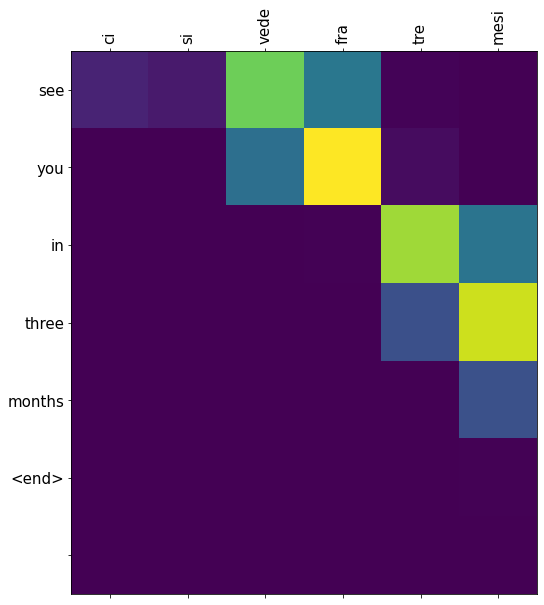

('ci si vede fra tre mesi', 'see you in three months <end> ')

In [ ]:
translate('ci si vede fra tre mesi')

Input: non penso che sia colpa mia
Predicted translation: i do not think it is my fault <end> 


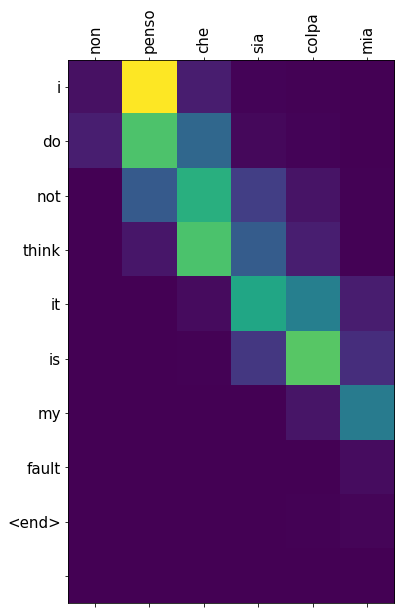

('non penso che sia colpa mia', 'i do not think it is my fault <end> ')

In [ ]:
translate('non penso che sia colpa mia')

Input: perché non lascia tom
Predicted translation: why do not you leave tom <end> 


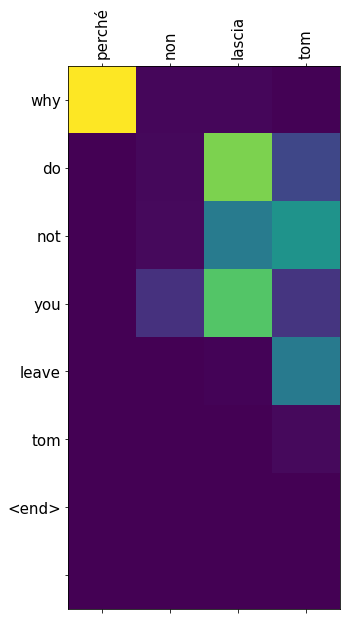

('perché non lascia tom', 'why do not you leave tom <end> ')

In [ ]:
translate('perché non lascia tom')

#### Calculation of Average BLEU score for concat scoring attention model

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu

np.random.seed(42)

bleu_scores_concat_list = []

for i in tqdm(range(1000)):
    id = np.random.randint(1,68677)
    actual_sent = [validation['english_out'].iloc[id].split(),]
    pred,_,_ = predict(validation['italian'].iloc[id])
    pred = pred.split()
    score = bleu.sentence_bleu(actual_sent, pred)
    bleu_scores_concat_list.append(score)

print('Average bleu score using general scoring is:',np.average(bleu_scores_concat_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

Average bleu score using general scoring is: 0.6186515775122491


## 7. Observations on each scoring function

### Observation on Dot Scoring


*  30 epochs were needed to get a BLEU score of 56.
*  In the dot scoring attention plot, more number of words are getting attention in sentence translation.



### Observation on General Scoring

*  35 epochs were needed to get a BLEU score of 54.
*  In the general scoring attention plot, very few number of words are getting attention in sentence translation.
*   General scoring based attention model took more time to train in comparison to dot scoring based and concat scoring based attention models. 





### Observations on Concat Scoring

*   25 epochs were needed to get a BLEU score of 62. This is the highest BLEU score which we have obtained so far.
*   In concat scoring attention plot many words are getting attention in sentence translation.
*   Concat scoring based attention model took the least time to train. 






## 8. References
https://appliedaicourse.com/